In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models,optimizers
import numpy as np
import os


import pandas as pd

In [2]:
train_dataset_dir = r"D:\\HGTS\\sign Language Detection\\Data\\train"
test_dataset_dir = r"D:\\HGTS\\sign Language Detection\\Data\\test"

In [3]:
batch_size = 32
img_height = 64
img_width = 64

train_ds =  tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=(64, 64),
    batch_size=32
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(64, 64),
    batch_size=32
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dataset_dir,
    image_size=(64, 64),
    batch_size=32
)


Found 17000 files belonging to 10 classes.
Using 11900 files for training.
Found 17000 files belonging to 10 classes.
Using 5100 files for validation.
Found 5000 files belonging to 10 classes.


In [4]:
# Define a data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("vertical"),          # Randomly flip images horizontally
    layers.RandomZoom(0.1),                   # Randomly zoom images by up to 10%
    layers.RandomBrightness(0.4),             # Randomly change brightness by up to 20%
])

# Apply data augmentation only on the training dataset
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize the augmented data
normalized_train_ds = augmented_train_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
normalized_train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalized_val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_ds.class_names), activation='softmax')
])

C:\Users\kumar\anaconda3\envs\GPU\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
 from tensorflow.keras.layers import Dropout

 model.add(Dropout(0.1)) 

In [8]:
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs=15,
)


Epoch 1/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5605 - loss: 2.2830 - val_accuracy: 0.9573 - val_loss: 0.2395
Epoch 2/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8571 - loss: 0.7268 - val_accuracy: 0.9857 - val_loss: 0.1044
Epoch 3/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8816 - loss: 0.4789 - val_accuracy: 0.9833 - val_loss: 0.1755
Epoch 4/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8844 - loss: 0.4067 - val_accuracy: 0.9910 - val_loss: 0.0872
Epoch 5/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8920 - loss: 0.3384 - val_accuracy: 0.9937 - val_loss: 0.1018
Epoch 6/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8860 - loss: 0.3266 - val_accuracy: 0.9780 - val_loss: 0.2825
Epoch 7/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8915 - loss: 0.3146 - val_accuracy: 0.9959 - val_loss: 0.0970
Epoch 8/15
372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8917 - loss: 0.3068 - val_acc

In [9]:
# Evaluate the model on the validation dataset to check accuracy
val_loss, val_accuracy = model.evaluate(normalized_val_ds)

print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9916 - loss: 0.0567
Validation Accuracy: 99.18%


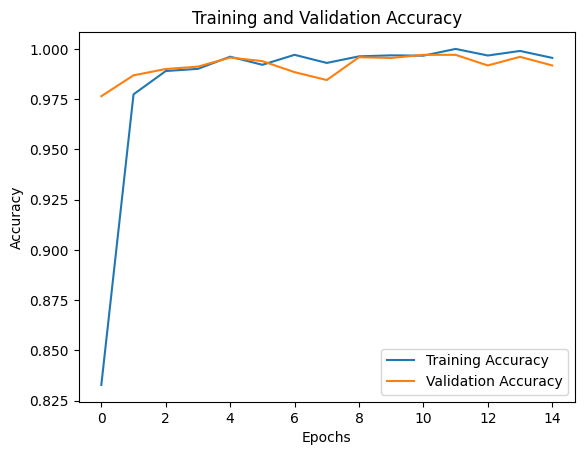

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score

# Predict on the validation dataset
true_labels = []
predicted_labels = []

for images, labels in normalized_val_ds:
    predictions = model.predict(images)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f"Precision: {precision:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

In [ ]:


def predict_hand_gesture(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    predicted_label = class_names[np.argmax(prediction)]
    
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()
    
    
    return predicted_label

     
# Example usage
#new_image_path = "D:\\HGTS\\predict\\hello.jpg"

new_image_path ="D:\\HGTS\\predict\\iloveu.jpg"
predicted_label = predict_hand_gesture(model, new_image_path, train_ds.class_names)
print(f'The predicted hand gesture is: {predicted_label}')


import os

def predict_gestures_from_folder(model, folder_path, class_names):
    # Get all image file paths from the folder
    img_paths = [
        os.path.join(folder_path, fname)
        for fname in os.listdir(folder_path)
        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))  # Add more extensions if needed
    ]
    
    for img_path in img_paths:
        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make a prediction
        prediction = model.predict(img_array)
        predicted_label = class_names[np.argmax(prediction)]

        # Display the image and prediction
        plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
        
        # Print the prediction
        print(f'The predicted hand gesture for {os.path.basename(img_path)} is: {predicted_label}')


# Example usage
folder_path = "D:\\HGTS\\predict"  # Path to the folder containing images
predict_gestures_from_folder(model, folder_path, train_ds.class_names)


In [12]:
import pyttsx3

def speak_text(text):
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()

# Example usage
speak_text(predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━

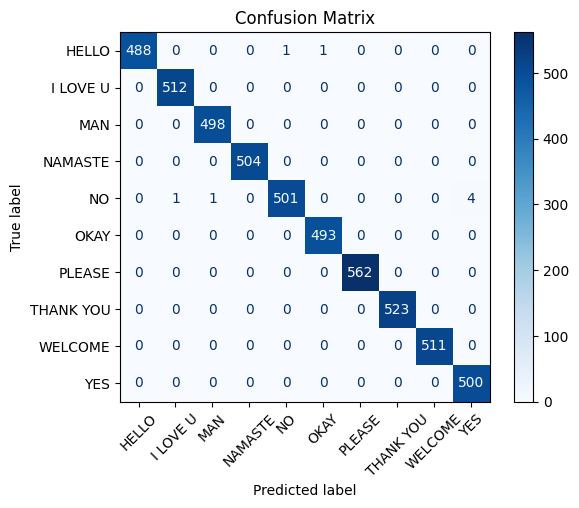

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation dataset
true_labels = []
predicted_labels = []

for images, labels in normalized_val_ds:
    predictions = model.predict(images)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix
class_names = train_ds.class_names
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [14]:
model.save("D:\\HGTS\\model\\MODEL_17.keras")

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 959,744 (3.66 MB)

 Trainable params: 319,914 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 639,830 (2.44 MB)

In [ ]:
END

In [6]:
import pyttsx3

def text_to_speech(text):
    # Initialize the pyttsx3 engine
    engine = pyttsx3.init()
    engine.say(text)
    engine.runAndWait()

# Example usage
user_input = "no please hello hello i love you"
text_to_speech(user_input)
